In [31]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
from PIL import Image, ImageDraw
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import re

import glob
import tqdm

In [2]:
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [3]:
client = genai.Client(api_key=GOOGLE_API_KEY)

In [4]:
# pathの設定
current_dir = Path().resolve()  # Current script directory
base_path = current_dir.parent  # Move two directory up
dataset_path = base_path / 'dataset' / 'testdata_crop_figure_20250215'

## 検証

In [97]:
sample_image_path = dataset_path / '配筋図' / 'A1_png' / '006-020_A1橋台配筋図(その1-15)_240202-A1(2).png'

In [98]:
sample_image = Image.open(sample_image_path)

In [99]:
prompt = (
  "The image of the input contains multiple cross sections. Return the bounding box for each cross section in this image."
  "in [ymin, xmin, ymax, xmax] format."
  )

response = client.models.generate_content(
  model="gemini-2.0-flash",
  contents=[sample_image, prompt])

print(response.text)

Here are the bounding box detections:
```json
[
  {"box_2d": [635, 508, 721, 757], "label": "cross section"},
  {"box_2d": [386, 686, 466, 796], "label": "cross section"},
  {"box_2d": [535, 508, 620, 761], "label": "cross section"},
  {"box_2d": [385, 510, 466, 610], "label": "cross section"},
  {"box_2d": [491, 87, 570, 350], "label": "cross section"},
  {"box_2d": [133, 74, 219, 351], "label": "cross section"},
  {"box_2d": [175, 509, 260, 772], "label": "cross section"},
  {"box_2d": [288, 507, 373, 772], "label": "cross section"}
]
```


In [100]:
prompt_ja = (
  "入力画像は複数の断面図を含みます。この画像の各断面図のバウンディングボックスを返してください。"
  "出力は [ymin, xmin, ymax, xmax] の形式で返してください。"
  )

response_ja = client.models.generate_content(
  model="gemini-2.0-flash",
  contents=[sample_image, prompt_ja])

print(response_ja.text)

次のバウンディングボックスを検出しました:
```json
[
  [
    717,
    36,
    578,
    446
  ],
  [
    719,
    479,
    579,
    901
  ],
  [
    105,
    61,
    375,
    425
  ],
  [
    107,
    492,
    376,
    903
  ],
  [
    380,
    478,
    712,
    940
  ],
  [
    377,
    59,
    713,
    440
  ],
  [
    737,
    1047,
    871,
    1468
  ],
  [
    521,
    1046,
    656,
    1469
  ],
  [
    899,
    1047,
    1031,
    1469
  ],
  [
    693,
    1514,
    830,
    1830
  ],
  [
    1081,
    1048,
    1212,
    1470
  ],
  [
    877,
    1515,
    1015,
    1831
  ],
  [
    1257,
    1048,
    1390,
    1469
  ],
  [
    1435,
    1048,
    1571,
    1470
  ],
  [
    1612,
    1048,
    1743,
    1469
  ],
  [
    754,
    396,
    811,
    540
  ],
  [
    799,
    398,
    844,
    670
  ],
  [
    1452,
    194,
    1716,
    378
  ],
  [
    1496,
    485,
    1690,
    678
  ],
  [
    1457,
    777,
    1714,
    962
  ],
  [
    1510,
    1315,
    1644,
    1383
  ],
  [
    8

In [101]:
def extract_bounding_boxes(response_text):
    """
    Geminiのレスポンステキストからバウンディングボックスを抽出する
    形式: [ymin, xmin, ymax, xmax] のリスト
    """
    if not isinstance(response_text, str):
        raise ValueError(f"Invalid response_text type: {type(response_text)}. Expected a string.")

    pattern = r"\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]"
    matches = re.findall(pattern, response_text)
    bounding_boxes = [tuple(map(int, match)) for match in matches]
    return bounding_boxes

In [102]:
def draw_bounding_boxes(image_path, bounding_boxes):
    """
    画像にバウンディングボックスを描画し、結果を表示する
    """
    image = Image.open(image_path).convert("RGB")  # 画像をRGBに変換

    # 読み込んだ画像の実際のサイズ
    w_actual, h_actual = image.size  # PILは (width, height)

    # 画像に描画
    draw = ImageDraw.Draw(image)

    for (ymin, xmin, ymax, xmax) in bounding_boxes:
        # スケール変換
        xmin_scaled = int(xmin / 1000 * w_actual)
        xmax_scaled = int(xmax / 1000 * w_actual)
        ymin_scaled = int(ymin / 1000 * h_actual)
        ymax_scaled = int(ymax / 1000 * h_actual)

        # 矩形を描画 (赤色, 線の太さ 5)
        draw.rectangle([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled], outline="red", width=5)

    # 画像を表示
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Detected Bounding Boxes (PIL)")
    plt.show()

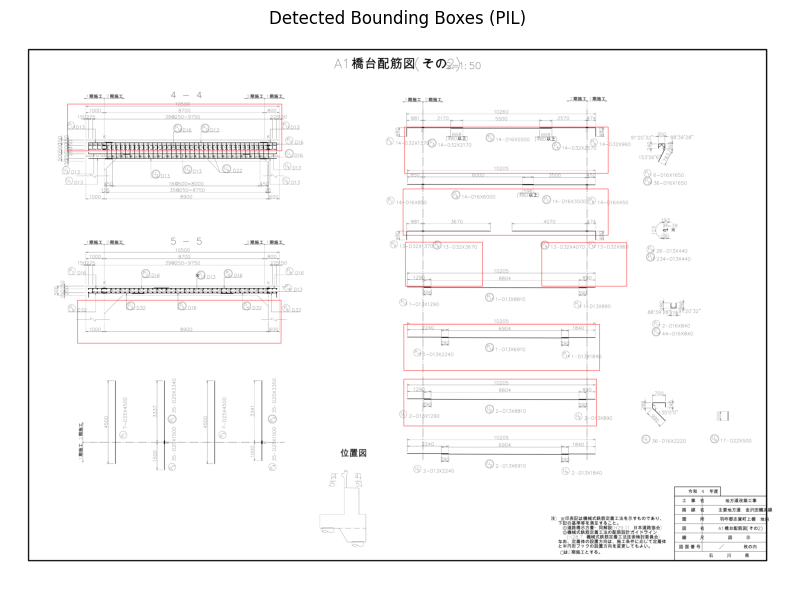

In [103]:
response_text = response.text
bounding_boxes = extract_bounding_boxes(response_text)
draw_bounding_boxes(sample_image_path, bounding_boxes)  # Geminiの画像サイズを指定

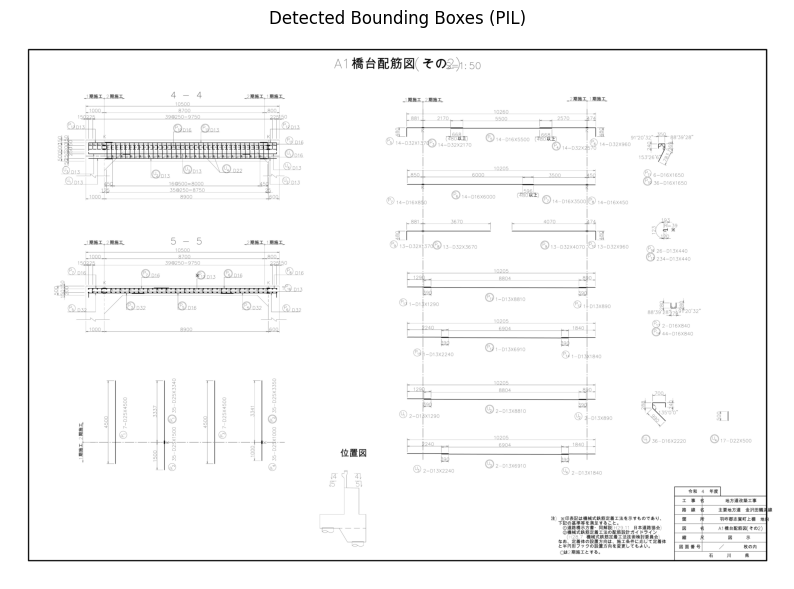

In [105]:
response_text_ja = response_ja.text
bounding_boxes = extract_bounding_boxes(response_text_ja)
draw_bounding_boxes(sample_image_path, bounding_boxes)

## 関数化

In [56]:
def crop_figures_by_gemni(image_path, output_dir):
    image = Image.open(image_path)
    
    prompt = (
    "The image of the input contains multiple cross sections. Return the bounding box for each cross section in this image."
    "in [ymin, xmin, ymax, xmax] format."
    )

    response = client.models.generate_content(
    model="models/gemini-2.0-flash",
    contents=[image, prompt])

    response_text = response.text
    
    if not isinstance(response_text, str):
        raise ValueError(f"Invalid response_text type: {type(response_text)}. Expected a string.")

    pattern = r"\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]"
    matches = re.findall(pattern, response_text)
    bounding_boxes = [tuple(map(int, match)) for match in matches]
    
    # 読み込んだ画像の実際のサイズ
    w_actual, h_actual = image.size  # PILは (width, height)

    # 画像に描画
    draw = ImageDraw.Draw(image)

    # 出力ディレクトリを作成
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for idx, (ymin, xmin, ymax, xmax) in enumerate(bounding_boxes):
        # スケール変換
        xmin_scaled = int(xmin / 1000 * w_actual)
        xmax_scaled = int(xmax / 1000 * w_actual)
        ymin_scaled = int(ymin / 1000 * h_actual)
        ymax_scaled = int(ymax / 1000 * h_actual)

        # 矩形を描画 (赤色, 線の太さ 5)
        draw.rectangle([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled], outline="red", width=5)

        # クロップ処理（PILを使用）
        cropped_image = image.crop((xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled))

        # 画像を保存
        output_image_name = f"{Path(image_path).stem}_{idx}.png"
        output_path = output_dir / output_image_name
        cropped_image.save(output_path)
        # print(f"Saved extracted figure to {output_path}")


    # 画像を表示
    # plt.figure(figsize=(10, 10))
    # plt.imshow(image)
    # plt.axis("off")
    # plt.title("Detected Bounding Boxes (PIL)")
    # plt.show()

In [57]:
# ディレクトリ内のすべての PNG に対して処理を実行
def process_all_images(png_dir_path, output_dir):
    image_paths = glob.glob(os.path.join(png_dir_path, "*.png"))
    for image_path in tqdm.tqdm(image_paths, desc="Processing images"):
        crop_figures_by_gemni(image_path, output_dir)

In [58]:
png_dir_name = 'A1_png'
png_dir_path = dataset_path / '配筋図' / f'{png_dir_name}'
output_dir = dataset_path / 'gemini_figure_result' / f'{png_dir_name}_figures'
os.makedirs(output_dir, exist_ok=True)
process_all_images(png_dir_path, output_dir)

Processing images: 100%|██████████| 16/16 [02:00<00:00,  7.52s/it]


In [59]:
png_dir_name = 'A2_png'
png_dir_path = dataset_path / '配筋図' / f'{png_dir_name}'
output_dir = dataset_path / 'gemini_figure_result' / f'{png_dir_name}_figures'
os.makedirs(output_dir, exist_ok=True)
process_all_images(png_dir_path, output_dir)

Processing images: 100%|██████████| 15/15 [02:01<00:00,  8.13s/it]


## 竪壁のある断面図の分類

In [60]:
import base64
from openai import OpenAI
import json
import shutil

In [61]:
def encode_image(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [62]:
# サンプル
sample_image_name = 'A1_1-1.png'
sample_image_path_01 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_01 =  encode_image(sample_image_path_01)

sample_image_name = 'A1_1-1_false_1.png'
sample_image_path_02 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_02 =  encode_image(sample_image_path_02)

sample_image_name = 'A1_1-1_false_2.png'
sample_image_path_03 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_03 =  encode_image(sample_image_path_03)

sample_image_name = 'A1_1-1_false_3.png'
sample_image_path_04 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_04 =  encode_image(sample_image_path_04)

'''
sample_image_name = 'A2_false_4.png'
sample_image_path_05 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_05 =  encode_image(sample_image_path_05)

sample_image_name = 'A2_false_5.png'
sample_image_path_06 = dataset_path / 'sample_image' / f'{sample_image_name}'
sample_image_06 =  encode_image(sample_image_path_06)
'''

"\nsample_image_name = 'A2_false_4.png'\nsample_image_path_05 = dataset_path / 'sample_image' / f'{sample_image_name}'\nsample_image_05 =  encode_image(sample_image_path_05)\n\nsample_image_name = 'A2_false_5.png'\nsample_image_path_06 = dataset_path / 'sample_image' / f'{sample_image_name}'\nsample_image_06 =  encode_image(sample_image_path_06)\n"

In [63]:
def identify_vertical_wall_image(image_path: str):
    base64_image = encode_image(image_path)
    # OpenAIクライアントの初期化
    client = OpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
    )
    prompt = """
    ## 指示
    - 入力は橋台の計画書において断面図を切り取った画像です。
    - 画像内に竪壁のある断面図があるか否かをTrue, Falseを使って分類してください。
    - サンプルとして竪壁のある断面図を与えます。そのサンプルと類似度がかなり高いものがある場合のみTrueを返してください。
    - 画像内の文字情報は考慮せずにサンプルで与えた断面図と類似したものがあるか否かのみで判定を行ってください。
    - 出力にはサンプルの画像とどのような部分で類似しているのかを明確に説明して下さい。
    - また、間違えやすい断面図も与えるのでそれに注意して分類をしてください。
    - 間違えやすい断面図と竪壁のある断面図の見分け方は直線の密集度です。密集度が間違いやすい例2のように高い場合はそれは竪壁のある断面図ではないので気を付けてください。
    - 一方、例1のように直線の密集度が低すぎる場合は、竪壁のある断面でもないので注意してください。
        
    ## 制約
    - 出力はJSON形式で以下のようにしてください。
    {{
        "reason": "竪壁のある断面図が含まれている画像であるか否かを推論するステップをここに記述",
        "vertical_wall_image": "竪壁の断面図か否かを判定するTrue or False"
    }}
    
    
    ## 例
    ### 竪壁のある断面図
    {sample_image_01}
    
    ## 竪壁のある断面図ではない画像(間違えやすい例)
    例1: {sample_image_02}
    例2: {sample_image_03}
    例3: {sample_image_04}
    
    ### 断面図の画像
        """
    

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt},
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'image_url',
                        'image_url': {'url': f'data:image/jpg;base64,{base64_image}'},
                    },
                ]
            }
        ],
        # max_tokens=4096,
        # temperature=0.7,
        response_format={'type': 'json_object'},
    )
    result = response.choices[0].message.content
    result = json.loads(result)
    print(result)
    result = result.get('vertical_wall_image')
    print(f'最終的な判定{result}')
    
    # resultが文字列の場合、ブール値に変換
    if isinstance(result, str):
        result = result.lower() == 'true'
    
    return result

In [64]:
# ディレクトリ内のすべての PNG に対して処理を実行（サイズフィルタリング付き）
def process_identify_vertical_wall_image_for_all_images(png_dir_path, output_dir, min_size=None, min_width=None, min_height=None):
    i = 0  # 竪壁を含む画像のカウント
    filtered_count = 0  # フィルタリング後の画像カウント
    image_paths = glob.glob(os.path.join(png_dir_path, "*.png"))
    
    for image_path in tqdm.tqdm(image_paths, desc="Processing images"):
        image_name = os.path.splitext(os.path.basename(image_path))[0]  # ファイル名のみ取得
        
        # 画像を開いてサイズを取得
        with Image.open(image_path) as img:
            width, height = img.size
            area = width * height

            # サイズ制限を満たしているかチェック
            if (min_size and area < min_size) or \
               (min_width and width < min_width) or \
               (min_height and height < min_height):
                print(f"Skipping {image_name}: does not meet size requirements")
                continue  # サイズが基準以下ならスキップ
        
        # フィルタリングを通過した画像のカウント
        filtered_count += 1
        # print(image_name)

        # 竪壁を含むかチェック
        if identify_vertical_wall_image(image_path):
            # Trueを返した場合のみ画像をコピー
            shutil.copy(image_path, output_dir)
            i += 1

    print(f'フィルタリング後の画像：{filtered_count}枚')
    print(f'竪壁のある断面の画像：{i}枚')

In [65]:
png_dir_name = 'A1_png_figures'
png_dir_path = dataset_path / 'gemini_figure_result' / f'{png_dir_name}'
output_dir = dataset_path / 'vertical_wall_figures' / f'gemini_{png_dir_name}'
os.makedirs(output_dir, exist_ok=True)
process_identify_vertical_wall_image_for_all_images(png_dir_path, output_dir, min_size=4000000, min_width=2000, min_height=2000 )

Processing images:   0%|          | 0/135 [00:00<?, ?it/s]

Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_27: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_27: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_20: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_14: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_22: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_4: does not meet size requirements


Processing images:   7%|▋         | 10/135 [00:04<00:56,  2.21it/s]

{'reason': 'The image appears to be a table containing numerical data and line drawings. There is no similarity to the provided example of a cross-section with a vertical wall. The drawings are simple lines and do not represent a complex structure like a vertical wall, nor is there a dense cluster of lines indicative of structural diagrams.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(11)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_0: does not meet size requirements


Processing images:  10%|▉         | 13/135 [00:08<01:30,  1.34it/s]

{'reason': 'The given cross-sectional image contains high density of vertical and horizontal lines creating a grid pattern, which resembles the characteristics of a vertical wall section. The straight vertical lines indicate structural reinforcement similar to vertical walls.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_5: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_12: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_4: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_16: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_5: does not meet size requirements


Processing images:  15%|█▍        | 20/135 [00:14<01:33,  1.23it/s]

{'reason': 'The image contains vertical straight lines with a consistent spacing, similar to structures typically incorporated in vertical wall section diagrams. The layout matches the characteristics of a typical vertical wall cross-section.', 'vertical_wall_image': 'True'}
最終的な判定True


Processing images:  16%|█▌        | 21/135 [00:19<02:10,  1.15s/it]

{'reason': 'The image depicts a cross-section with grid lines and evenly spaced vertical elements, indicating a high density of lines that matches features of a vertical wall drawing. The density and arrangement of lines suggest a structure that may contain a vertical wall.', 'vertical_wall_image': True}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_25: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_17: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_5: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(6)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_23: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_7: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_26: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-

Processing images:  23%|██▎       | 31/135 [00:23<01:18,  1.33it/s]

{'reason': 'The image does not resemble the sample image of a cross-section with a vertical wall due to its dense grid-like pattern and multiple parallel lines, which aligns more with the characteristics of a common non-vertical wall cross-section example.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  24%|██▎       | 32/135 [00:27<01:40,  1.03it/s]

{'reason': 'The image contains a cross-section with a dense grid pattern and straight lines, which matches the characteristics of an image with a vertical wall section. The structure is similar to the provided sample of an image with a vertical wall.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_15: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_5: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_11: does not meet size requirements


Processing images:  27%|██▋       | 36/135 [00:31<01:39,  1.01s/it]

{'reason': 'The image depicts a structural cross-section with a clear vertical alignment of lines, reminiscent of the sample image containing a vertical wall. The density and configuration of the lines suggest the presence of a vertical wall.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_4: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_21: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_20: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_12: does not meet size requirements


Processing images:  30%|███       | 41/135 [00:35<01:25,  1.10it/s]

{'reason': 'The section drawing contains a distinct vertical wall-like structure with parallel lines indicating wall edges and reinforcement. The density of these lines resembles the provided sample of a vertical wall cross-section.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_2: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_24: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_6: does not meet size requirements


Processing images:  34%|███▍      | 46/135 [00:39<01:14,  1.19it/s]

{'reason': 'The image has a dense grid pattern indicating a complex structure, but lacks specific features identified in sample images as indicative of a vertical wall cross-section, e.g., distinct vertical alignment or less line density.', 'vertical_wall_image': 'False'}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(15)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_13: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_29: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_18: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(3)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(3)_4: does not mee

Processing images:  43%|████▎     | 58/135 [00:44<00:48,  1.60it/s]

{'reason': 'The image displays a section with a high density of lines, similar to example 2 of problematic images without vertical walls. The density of lines is very high, potentially representing a reinforced area, which does not typically indicate a vertical wall.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(9)_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_24: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_4: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_9: does not meet size requirements


Processing images:  47%|████▋     | 63/135 [00:48<00:49,  1.44it/s]

{'reason': 'The image contains cross-sectional drawings with moderate line density. The structure is generally horizontal with occasional vertical elements, but there are no prominent or distinct vertical walls resembling the sample image of a tateheki. The visual elements do not significantly match the characteristic features of a vertical wall section.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(3)_2: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_9: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_17: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_15: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_19: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_26: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1

Processing images:  55%|█████▍    | 74/135 [00:52<00:33,  1.83it/s]

{'reason': 'The image consists of horizontal bars with spacing between them and accompanying text. There are no vertical elements or complexity similar to the sample image with a vertical wall. The lines are uniformly distributed without the denser pattern seen in typical vertical wall diagrams.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_25: does not meet size requirements


Processing images:  57%|█████▋    | 77/135 [00:57<00:40,  1.41it/s]

{'reason': 'The image displays a section view with a very dense grid of lines, similar to the misleading examples provided. The regular pattern and the density suggest that it is not a vertical wall image, which typically has specific characteristics distinct from this pattern.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  58%|█████▊    | 78/135 [01:02<00:55,  1.03it/s]

{'reason': 'The image is a table with numerical and textual data for construction purposes, not a cross-sectional diagram. There are no discernible features of a vertical wall section similar to the sample.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_18: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_7: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_1: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_7: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_10: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_11: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_9: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_1: does not meet size requirements


Processing images:  65%|██████▌   | 88/135 [01:07<00:35,  1.34it/s]

{'reason': 'The image displays a high density of straight lines closely packed together, which resembles the false positive examples with high line density and is indicative of a structure without a vertical wall characteristic.', 'vertical_wall_image': False}
最終的な判定False
Skipping test_20250215_2: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_11: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_6: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_10: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_2: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_6: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_28: does not meet size requirements
Skipping 006-020

Processing images:  77%|███████▋  | 104/135 [01:11<00:15,  2.05it/s]

{'reason': 'The image contains a section view with a high density of intersecting lines, but it does not match the specific features of the sample image with a vertical wall section. The dense lines resemble the typical example 2, which is indicated not to be a vertical wall section.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_13: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_5: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_9: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_28: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_4: does not meet size requirements


Processing images:  82%|████████▏ | 111/135 [01:15<00:11,  2.03it/s]

{'reason': 'The image contains a cross-section with vertical elements resembling the sample image of a section with a vertical wall. The elements are distinct and structured in a way that indicates the presence of a vertical wall.', 'vertical_wall_image': True}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_23: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_2: does not meet size requirements


Processing images:  85%|████████▌ | 115/135 [01:19<00:12,  1.65it/s]

{'reason': 'The image contains a dense pattern of vertical and horizontal lines indicating a higher density of straight lines, similar to the confusing example where such patterns are evident. This suggests it likely does not correspond to a typical vertical wall structure.', 'vertical_wall_image': 'False'}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(2)_2: does not meet size requirements
Skipping test_20250215_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_21: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(1)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_10: does not meet size requirements
Skipping test_20250215_0: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(15)_2: does not meet size requirements


Processing images:  92%|█████████▏| 124/135 [01:23<00:05,  1.87it/s]

{'reason': 'The image does not show the distinctive characteristics of a vertical wall cross-section as the lines do not form a structure resembling a vertical wall. The density of the lines is moderate, consistent with images that typically do not contain vertical walls.', 'vertical_wall_image': 'False'}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(8)_9: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_10: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(10)_6: does not meet size requirements


Processing images:  95%|█████████▍| 128/135 [01:28<00:04,  1.47it/s]

{'reason': 'The image contains a table with text and symbols, but no sectional diagrams are present that resemble the sample image of a vertical wall. The image does not exhibit any structural characteristics of a vertical wall section.', 'vertical_wall_image': False}
最終的な判定False
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_2: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(5)_8: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_30: does not meet size requirements


Processing images: 100%|██████████| 135/135 [01:31<00:00,  1.47it/s]

{'reason': 'The image contains a section view with a dense pattern of straight lines similar to the sample image of a vertical wall section. The pattern density indicates the presence of a vertical wall.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(14)_3: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_29: does not meet size requirements
Skipping 006-020_A1橋台配筋図(その1-15)_240202-A1(4)_6: does not meet size requirements
フィルタリング後の画像：21枚
竪壁のある断面の画像：8枚


In [66]:
png_dir_name = 'A2_png_figures'
png_dir_path = dataset_path / 'gemini_figure_result' / f'{png_dir_name}'
output_dir = dataset_path / 'vertical_wall_figures' / f'gemini_{png_dir_name}'
os.makedirs(output_dir, exist_ok=True)
process_identify_vertical_wall_image_for_all_images(png_dir_path, output_dir, min_size=4000000, min_width=2000, min_height=2000)

Processing images:   1%|▏         | 1/76 [00:03<04:30,  3.61s/it]

{'reason': 'The image is a table containing information about construction elements such as diameter, length, and weight, along with symbols. There is no cross-section diagram present.', 'vertical_wall_image': False}
最終的な判定False


Processing images:   3%|▎         | 2/76 [00:07<04:41,  3.81s/it]

{'reason': 'The image shows a section with dense grid lines and vertical lines. The arrangement of these lines suggests the presence of a structural element, but given the high density and pattern type, it resembles more closely the complex grid pattern in the misleading examples rather than the simpler pattern typical of sections with vertical walls.', 'vertical_wall_image': False}
最終的な判定False


Processing images:   4%|▍         | 3/76 [00:11<04:57,  4.07s/it]

{'reason': "The image is a table with structural specifications and does not contain any sectional diagrams, either with or without vertical walls. There are shape-like symbols, but they don't match the characteristics of a section with a vertical wall.", 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_4: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_7: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_1: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(3)_6: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_3: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(1)_2: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_1: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(2)_6: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(15)_0: 

Processing images:  24%|██▎       | 18/76 [00:15<00:35,  1.65it/s]

{'reason': 'The image contains dense linear elements and lacks the defining characteristics of a vertical wall cross-section. The arrangement does not closely resemble the sample images with vertical walls.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  25%|██▌       | 19/76 [00:19<00:49,  1.15it/s]

{'reason': 'The image depicts a section with features that do not resemble the characteristics of a 竪壁 (vertical wall) cross section as specified in the samples. The straight lines show a different configuration, possibly with a higher or lower density than expected for a vertical wall, and the pattern does not match the sample provided for vertical walls.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  26%|██▋       | 20/76 [00:23<01:04,  1.15s/it]

{'reason': 'The image depicts a cross-sectional drawing with a dense arrangement of straight lines forming a structure typical of a vertical wall seen in such engineering or architectural plans. The detailed representation and layout match the characteristics of a typical vertical wall section as per the sample provided.', 'vertical_wall_image': True}
最終的な判定True


Processing images:  28%|██▊       | 21/76 [00:27<01:25,  1.56s/it]

{'reason': 'The image contains a high density of lines forming a grid pattern, which suggests reinforcement or structural detailing rather than representing a vertical wall section as defined by the sample image. The lower section shows distinct linear elements, but lacks the characteristic vertical wall aspect.', 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_7: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(14)_6: does not meet size requirements


Processing images:  32%|███▏      | 24/76 [00:32<01:23,  1.61s/it]

{'reason': 'The image shows a dense grid of intersecting horizontal and vertical lines similar to the provided reference of a vertical wall section. The line density and arrangement closely resemble that of a true vertical wall structure.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_5: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(1)_4: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(15)_3: does not meet size requirements


Processing images:  37%|███▋      | 28/76 [00:36<01:04,  1.35s/it]

{'reason': 'The cross-section in the image shows a sloped wall leading to a horizontal section, without a distinct vertical wall similar to the sample provided. The linear density is relatively low, indicating the absence of a vertical wall.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  38%|███▊      | 29/76 [00:40<01:20,  1.72s/it]

{'reason': 'The image contains a table of measurements and weights, along with several line drawings that could potentially represent cross-sectional views. However, the line drawings here appear too simplistic and lack the distinctive high-density straight lines that would typically indicate a vertical wall cross-section, based on the criteria provided.', 'vertical_wall_image': 'False'}
最終的な判定False


Processing images:  39%|███▉      | 30/76 [00:45<01:41,  2.20s/it]

{'reason': 'The image displays a section drawing with several horizontal and some vertical lines, but it does not exhibit the characteristic features of a section drawing with a vertical wall. The presence of separated components and the spacing between lines do not resemble the sample image of a section with a vertical wall.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  41%|████      | 31/76 [00:50<01:59,  2.65s/it]

{'reason': 'The image shows a cross-section with a moderate density of vertical and horizontal lines, which suggests a structured design indicative of a vertical wall. However, the pattern also shows a grid-like structure with moderately spaced lines.', 'vertical_wall_image': 'True'}
最終的な判定True


Processing images:  42%|████▏     | 32/76 [00:56<02:30,  3.41s/it]

{'reason': 'The image contains tables with numerical data and symbols, but there are no clear sectional diagrams or visual representations to analyze for the presence of vertical walls. Therefore, it is not possible to determine if a vertical wall section is present.', 'vertical_wall_image': 'False'}
最終的な判定False


Processing images:  43%|████▎     | 33/76 [01:01<02:36,  3.63s/it]

{'reason': 'The image contains a dense grid of lines, including circular patterns, but lacks distinctive vertical wall structures with varied density, which are characteristics of a vertical wall section. The straight lines are highly dense and consistent, similar to the provided misleading examples.', 'vertical_wall_image': 'False'}
最終的な判定False


Processing images:  45%|████▍     | 34/76 [01:05<02:41,  3.83s/it]

{'reason': "The image contains a list of specifications and symbols, but there are no detailed sectional views present to match with the '竪壁' (vertical wall) sample provided. The content consists mostly of tabular data and linear symbols.", 'vertical_wall_image': False}
最終的な判定False


Processing images:  46%|████▌     | 35/76 [01:10<02:47,  4.10s/it]

{'reason': "The image contains a high density of straight lines, similar to mistake example 2, which suggests it's not a vertical wall cross-section.", 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_2: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_4: does not meet size requirements


Processing images:  50%|█████     | 38/76 [01:14<01:38,  2.60s/it]

{'reason': '画像には竪壁が明確に描かれており、断面図に直線の集合体が竪壁を形成していることが確認できる。サンプル画像と比較しても竪壁の特徴が一致している。', 'vertical_wall_image': True}
最終的な判定True
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_1: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(15)_1: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_6: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_8: does not meet size requirements


Processing images:  57%|█████▋    | 43/76 [01:17<00:49,  1.51s/it]

{'reason': 'The image contains sketches that need to be analyzed for vertical wall sections. Upon observation, none of the sketches match the specific characteristics of a vertical wall cross-section with the required line density balance.', 'vertical_wall_image': 'False'}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_9: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(3)_3: does not meet size requirements


Processing images:  61%|██████    | 46/76 [01:21<00:42,  1.41s/it]

{'reason': 'The image is a table with numerical and text data, likely related to construction or materials, with no diagram or sectional view present.', 'vertical_wall_image': 'False'}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(2)_4: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_4: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(3)_4: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(14)_8: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_2: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(2)_5: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_6: does not meet size requirements


Processing images:  71%|███████   | 54/76 [01:24<00:19,  1.11it/s]

{'reason': 'The image shows low density of lines with a clear structure and vertical elements, similar to the sample where a vertical wall is present. The design appears aligned with structural elements that suggest the presence of a vertical wall.', 'vertical_wall_image': 'True'}
最終的な判定True


Processing images:  72%|███████▏  | 55/76 [01:28<00:23,  1.10s/it]

{'reason': 'The cross-section does not display features indicative of a vertical wall profile, such as the distinct arrangement and density of lines characteristic of true examples.', 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_1: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(13)_3: does not meet size requirements


Processing images:  76%|███████▋  | 58/76 [01:34<00:24,  1.35s/it]

{'reason': 'The image displays a densely packed arrangement of vertical and horizontal lines, similar to the misleading examples where dense lines are not indicative of a vertical wall section.', 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_6: does not meet size requirements


Processing images:  79%|███████▉  | 60/76 [01:38<00:23,  1.48s/it]

{'reason': 'The cross-section in the image shows a structure with a noticeable vertical element that resembles the characteristic features of a 竪壁 (vertical wall). The straight lines are not overly dense and align with the typical vertical layout of a 竪壁.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(1)_3: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_5: does not meet size requirements


Processing images:  83%|████████▎ | 63/76 [01:41<00:18,  1.39s/it]

{'reason': 'The image shows a cross-section with relatively few lines and clear distinctions between components, similar to what might be expected in a vertical wall cross-section. However, the arrangement and structure do not strongly match the vertical wall sample closely enough.', 'vertical_wall_image': False}
最終的な判定False


Processing images:  84%|████████▍ | 64/76 [01:44<00:19,  1.61s/it]

{'reason': 'The image displays a section drawing with vertical elements typical of a design featuring a vertical wall. The central structure has distinct vertical bars and a defined rectangular shape that resembles the sample image of a vertical wall.', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(2)_2: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_0: does not meet size requirements


Processing images:  88%|████████▊ | 67/76 [01:48<00:13,  1.50s/it]

{'reason': 'The cross-section diagram in the image does not resemble the sample with vertical walls. The density of lines and the structure layout suggest it is not indicative of having vertical walls as defined by the sample.', 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(12)_8: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(3)_1: does not meet size requirements


Processing images:  92%|█████████▏| 70/76 [01:53<00:09,  1.52s/it]

{'reason': 'The image displays a cross-section with a grid pattern and circular shapes, but lacks the specific features or configuration that uniquely define a vertical wall section as in the provided sample images.', 'vertical_wall_image': False}
最終的な判定False
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(2)_3: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(4)_0: does not meet size requirements


Processing images:  96%|█████████▌| 73/76 [01:56<00:04,  1.38s/it]

{'reason': 'The image contains a grid pattern with a high concentration of straight lines, similar to the misleading example. The density of the lines suggests it is not a vertical wall section.', 'vertical_wall_image': False}
最終的な判定False


Processing images: 100%|██████████| 76/76 [02:00<00:00,  1.59s/it]

{'reason': 'この断面図には取り扱う直線の密集度が中程度で、竪壁の特徴である均一に並べられた線が見られます。また、線の配置がサンプル画像と類似しています。', 'vertical_wall_image': 'True'}
最終的な判定True
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(15)_2: does not meet size requirements
Skipping 082-096_A2橋台配筋図(その1-15)_240202-A2(10)_8: does not meet size requirements
フィルタリング後の画像：29枚
竪壁のある断面の画像：8枚


# 以下実験用

In [28]:
image_name = '006-020_A1橋台配筋図(その1-15)_240202-A1(1).png'
image_path = dataset_path / '配筋図' / 'A1_png' / f'{image_name}'

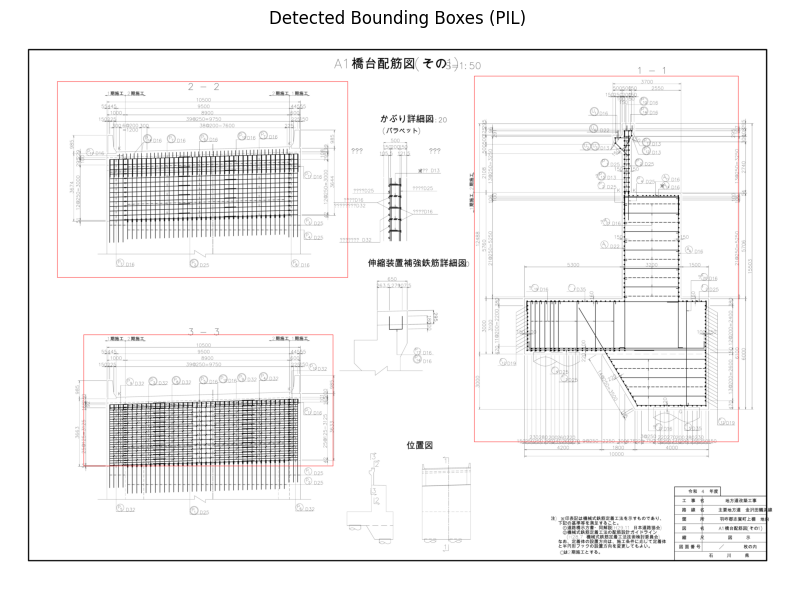

In [29]:
crop_figures_by_gemni(image_path)